## Задание

ДЗ - Используя torch решить на выбор одну домашнюю работу. 

## Решение

Отобразим произвольные 40 файлов изображений из набора обработанных данных


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
cropped_images = pd.read_csv('imdb_crops.csv', index_col='Unnamed: 0')

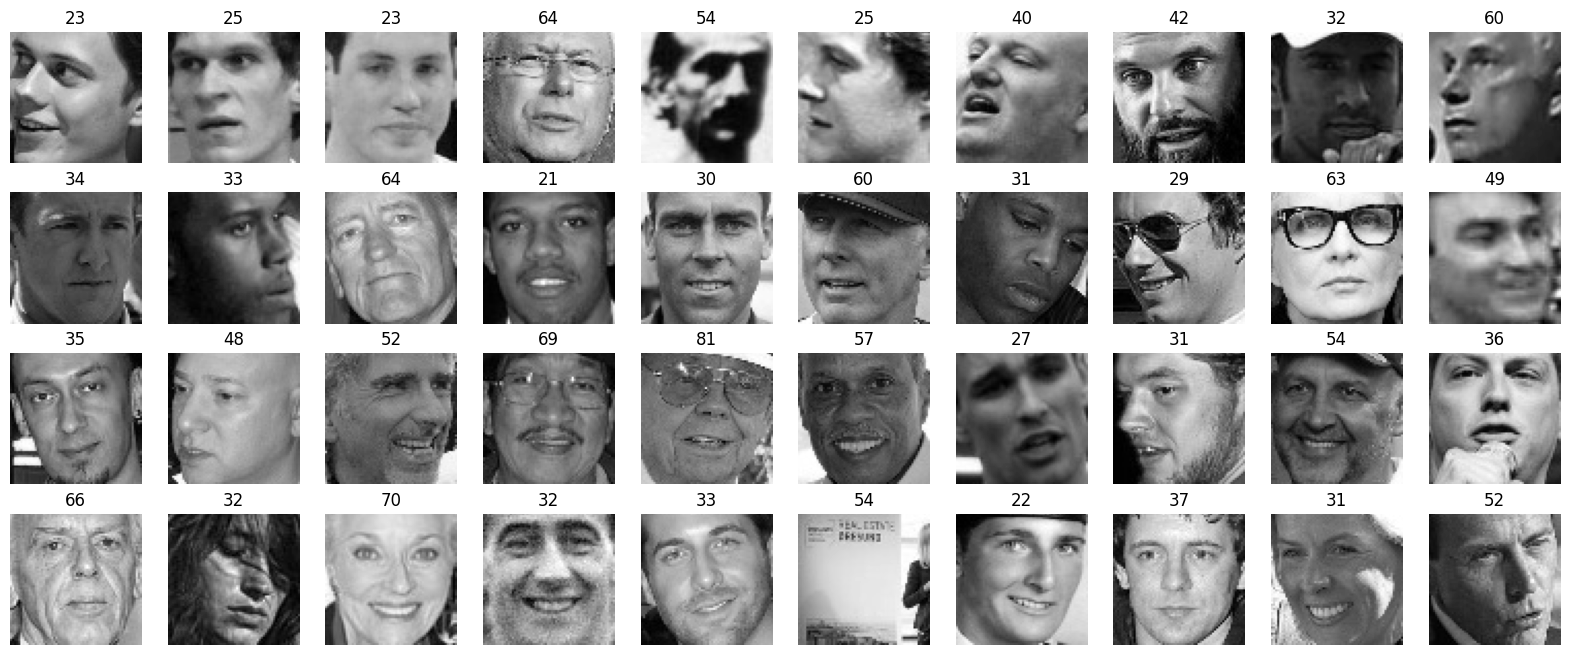

In [3]:
df = cropped_images
fig, ax = plt.subplots(4, 10, figsize=(20, 8))

for i in range(4):
    for j in range(10):
        idx = np.random.choice(range(df.shape[0]))
        file, label = df.iloc[idx].file_path, df.iloc[idx].label
        ax[i, j].imshow(plt.imread(file), cmap='gray')
        ax[i, j].set_title(label)
        ax[i, j].axis('off')

In [4]:
cropped_images.head()

,file_path,label
0,final_folder\10049200_1891-09-16_1958.jpg,67
1,final_folder\10110600_1985-09-17_2012.jpg,27
2,final_folder\1013900_1917-10-15_1960.jpg,43
3,final_folder\10166400_1960-03-12_2008.jpg,48
4,final_folder\10292500_1984-03-26_2009.jpg,25


In [5]:
cropped_images.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35070 entries, 0 to 35069
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  35070 non-null  object
 1   label      35070 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 822.0+ KB


In [6]:
cropped_images['label'] = cropped_images['label'].astype(np.float32)

In [7]:
import random
import pandas as pd

def train_test_split(data, test_size=0.2, random_state=None):
    """
    Разбивает данные на обучающую и тестовую выборки.

    Параметры:
    - data: pandas DataFrame для разбиения.
    - test_size: доля тестовой выборки (от 0 до 1).
    - random_state: случайное состояние для воспроизводимости разбиения.

    Возвращает:
    - train_data: обучающая выборка (pandas DataFrame).
    - test_data: тестовая выборка (pandas DataFrame).
    """
    if random_state:
        random.seed(random_state)

    # Получение случайного индекса для разбиения
    test_size = int(len(data) * test_size)
    indices = random.sample(range(len(data)), test_size)

    # Разбиение данных на обучающую и тестовую выборки
    train_data = data.drop(indices)
    test_data = data.loc[indices]

    return train_data, test_data

train_data, test_data = train_test_split(cropped_images, test_size=0.2, random_state=42)

In [8]:
train_data.reset_index(drop=True, inplace=True)

In [9]:
test_data.reset_index(drop=True, inplace=True)

In [10]:
train_data

,file_path,label
0,final_folder\10049200_1891-09-16_1958.jpg,67.0
1,final_folder\10110600_1985-09-17_2012.jpg,27.0
2,final_folder\1013900_1917-10-15_1960.jpg,43.0
3,final_folder\10292500_1984-03-26_2009.jpg,25.0
4,final_folder\10623500_1931-09-25_1956.jpg,25.0
...,...,...
28051,final_folder\961599_1950-01-12_2009.jpg,59.0
28052,final_folder\9799_1960-06-22_2012.jpg,52.0
28053,final_folder\9811999_1953-06-14_2004.jpg,51.0
28054,final_folder\981199_1954-12-30_2006.jpg,52.0


In [25]:
import matplotlib.pylab as plt
import numpy as np

from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile
from sklearn.metrics import mean_absolute_error
torch.manual_seed(0)

ImageFile.LOAD_TRUNCATED_IMAGES=True

In [12]:
# Создадим класс датасета
class Dataset(Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.len = len(self.df) 
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        path = self.df.loc[idx, 'file_path'] 
        img = Image.open(path)
        
        if self.transform:
            img = self.transform(img)
            
        label = self.df.loc[idx, 'label']
        return img, label

In [13]:
torch.__version__

'2.0.1'

Настройка загрузчиков данных

In [17]:
img_transforms = transforms.Compose([
    transforms.ToTensor()
    ])

In [18]:
# Generate the training dataset
traindata = Dataset(train_data, transform=img_transforms)
testndata = Dataset(test_data, transform=img_transforms)

In [19]:
batch_size = 64

# Load the training data into data loader with the 
# respective batch_size and num_workers
trainloader = DataLoader(traindata, batch_size=batch_size, num_workers=0)
testloader = DataLoader(testndata, batch_size=batch_size, num_workers=0)

In [40]:
class AgePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*256, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = self.fc2(x)
        return x


In [41]:
model = AgePredictor()
model

AgePredictor(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [42]:
torch.save(model,'torch_model.pt')

In [43]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=15, device="cuda:0"):
    min_loss = float('inf')
    train_losses = []
    valid_losses = []
    train_maes = []
    valid_maes = []
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        train_mae = 0.0
        valid_mae = 0.0
        valid_loss = 0.0
        model.train()

        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.view(-1, 1).to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.item() * inputs.size(0)
            train_mae += mean_absolute_error(targets.cpu().detach().numpy(), output.cpu().detach().numpy()) * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        train_mae /= len(train_loader.dataset)
        
        model.eval()
        
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.view(-1, 1).to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.item() * inputs.size(0)
            valid_mae += mean_absolute_error(targets.cpu().detach().numpy(), output.cpu().detach().numpy()) * inputs.size(0)

            
        valid_loss /= len(val_loader.dataset)
        valid_mae /= len(val_loader.dataset)
        if valid_loss < min_loss:
            min_loss = valid_loss
            torch.save(model.state_dict(), f'model_{epoch}.pt')
        
        print(f'Epoch: {epoch}, Train Loss: {training_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train MAE: {train_mae:.4f}, Valid MAE: {valid_mae:.4f}')

        train_losses.append(training_loss)
        valid_losses.append(valid_loss)
        train_maes.append(train_mae)
        valid_maes.append(valid_mae)

    # Построим графики
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.legend()
    plt.title('Losses')

    plt.subplot(1, 2, 2)
    plt.plot(train_maes, label='Train MAE')
    plt.plot(valid_maes, label='Valid MAE')
    plt.legend()
    plt.title('MAE')

    plt.show()

In [44]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
else:
    device = torch.device("cpu")

In [45]:
device

device(type='cuda', index=0)

Epoch: 1, Train Loss: 351.1361, Valid Loss: 320.8415, Train MAE: 14.7818, Valid MAE: 13.7755
Epoch: 2, Train Loss: 299.7678, Valid Loss: 277.4088, Train MAE: 13.7749, Valid MAE: 12.9267
Epoch: 3, Train Loss: 257.6199, Valid Loss: 231.7485, Train MAE: 12.6269, Valid MAE: 11.7680
Epoch: 4, Train Loss: 227.4857, Valid Loss: 219.3325, Train MAE: 11.7429, Valid MAE: 11.5439
Epoch: 5, Train Loss: 214.4015, Valid Loss: 204.7254, Train MAE: 11.3874, Valid MAE: 11.0032
Epoch: 6, Train Loss: 199.8395, Valid Loss: 199.0902, Train MAE: 10.9476, Valid MAE: 10.8962
Epoch: 7, Train Loss: 189.2320, Valid Loss: 221.7304, Train MAE: 10.6608, Valid MAE: 11.1908
Epoch: 8, Train Loss: 179.4131, Valid Loss: 186.9847, Train MAE: 10.3309, Valid MAE: 10.3704
Epoch: 9, Train Loss: 169.7852, Valid Loss: 188.7726, Train MAE: 10.0273, Valid MAE: 10.7291
Epoch: 10, Train Loss: 158.9083, Valid Loss: 175.6840, Train MAE: 9.6965, Valid MAE: 10.2922
Epoch: 11, Train Loss: 150.0601, Valid Loss: 177.0644, Train MAE: 9.42

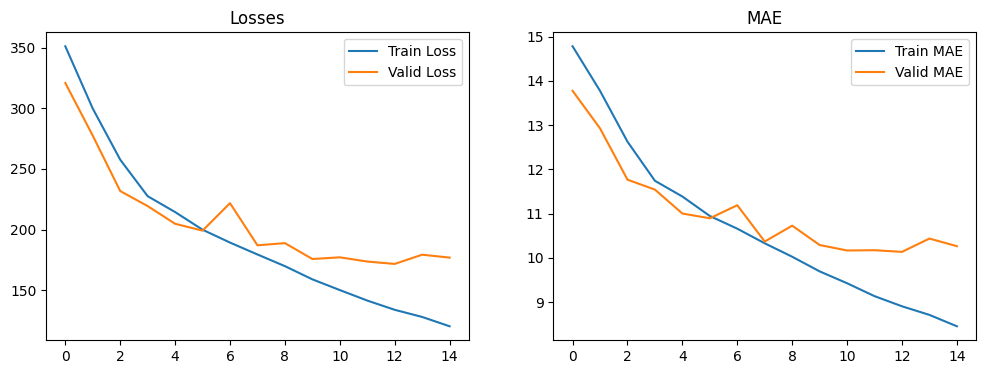

In [46]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
else:
    device = torch.device("cpu")

loss_fn = torch.nn.MSELoss()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, optimizer, loss_fn, trainloader, testloader, epochs=15, device=device)

Видим что модель обучается

Загрузим лучшую модель

In [47]:
model.load_state_dict(torch.load('model_13.pt'))

<All keys matched successfully>

Проверим как модель предсказывает возраст

In [51]:
model.eval()
#model.half()
x = torch.rand(3, 1, 64, 64, requires_grad=True).to(device)
torch_out = model(x)
torch_out

tensor([[60.5646],
        [66.5079],
        [54.5925]], device='cuda:0', grad_fn=<AddmmBackward0>)

Сохраним модель в ONNX

In [53]:
model.eval()
torch.onnx.export(model,                       # model being run
                      x,                           # model input (or a tuple for multiple inputs)
                      'age_model.onnx',                   # where to save the model (can be a file or file-like object)
                      export_params=True,          # store the trained parameter weights inside the model file
                      opset_version=17,            # the ONNX version to export the model to
                      do_constant_folding=True,    # whether to execute constant folding for optimization
                      input_names=["input"],       # the model's input names
                      output_names=["output"],     # the model's output names
                      dynamic_axes={"input": {0: "batch_size"},  # variable length axes
                                    "output": {0: "batch_size"}},
                                    operator_export_type=torch.onnx.OperatorExportTypes.ONNX_ATEN_FALLBACK)

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

